Xavier Castellanos-Girouard <br>
<br>
Reconstruction of GI matrix using PPIs <br>
<br>
Date First Created: March 17 2024 <br>
Date Last Modified: May 28 2024 <br>

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import scipy.optimize as optimization
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from itertools import combinations
from itertools import repeat

## Import Data

In [2]:
directory = "/home/xavier/Desktop/Cell_interactome_stoichiometry/Yeast_Epistasis_Stoichiometries/Third_Run/"

Kd_GI_Network_DF = pd.read_csv(directory+"R_Kd_vs_GI/results/Yeast_Kd_GI.csv", index_col=0)
Kd_GI_Network_DF

,source,target,source_copy_number,target_copy_number,Abundance_Stoichiometry,Interaction_Stoichiometry,Complex_CopyNumber,Source_FreeAbundance,Target_FreeAbundance,Complex_Conc,Source_FreeConc,Target_FreeConc,Kd,pval,scores,strain_query,strain_array
1,YAL001C,YPL007C,1809.037121,1632.262059,0.902282,0.025201,45.589964,1763.447157,1586.672094,9.232401e-10,3.571148e-08,3.213162e-08,1.242870e-06,1.326000e-38,-0.5784,tsq508,tsa1201
2,YAL007C,YKR067W,6820.511400,3692.271780,0.541348,0.011236,76.634514,6743.876886,3615.637266,1.551922e-09,1.365699e-07,7.322009e-08,6.443406e-06,7.944000e-02,0.0226,sn184,dma2995
3,YAL007C,YML012W,6820.511400,13235.516720,1.940546,0.103956,709.035961,6111.475439,12526.480759,1.435865e-08,1.237632e-07,2.536731e-07,2.186514e-06,2.502000e-05,0.0671,sn184,dma3523
4,YAL011W,YJL081C,1122.280275,4234.973897,3.773544,0.018166,20.387450,1101.892825,4214.586448,4.128652e-10,2.231438e-08,8.534938e-08,4.612929e-06,1.887000e-02,0.1402,sn1778,tsa618
5,YAL011W,YNL107W,1122.280275,1257.326071,1.120332,0.084197,94.492561,1027.787714,1162.833510,1.913564e-09,2.081368e-08,2.354848e-08,2.561349e-07,4.785000e-01,0.0035,sn1778,dma4012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3261,YPR184W,YKR058W,3531.969988,1487.490488,0.421150,0.016869,59.579888,3472.390100,1427.910600,1.206549e-09,7.031920e-08,2.891655e-08,1.685292e-06,3.124000e-01,-0.0174,sn2870,dma5156
3262,YPR185W,YJL209W,1535.735853,1964.702889,1.279323,0.818321,1256.724799,279.011053,707.978090,2.544987e-08,5.650239e-09,1.433723e-08,3.183072e-09,2.824000e-01,-0.0320,sn1683,dma5155
3263,YPR190C,YKL144C,4623.205271,2094.641991,0.453071,0.053580,247.713124,4375.492146,1846.928867,5.016426e-09,8.860787e-08,3.740206e-08,6.606531e-07,2.152000e-01,-0.0372,tsq1362,tsa1238
3264,YPR190C,YNL151C,4623.205271,3399.366560,0.735284,0.621845,2874.916083,1748.289188,524.450477,5.821978e-08,3.540452e-08,1.062062e-08,6.458594e-09,5.973000e-107,-0.4845,tsq2241,tsa1238


## Find the Optimal Number of Quantiles for Distance vs. GI Fit

In [3]:
def exp_func(dist, a, r): # Exponential fit
    exponential = a*np.exp(r*dist)
    return exponential

def lin_func(dist, a): # Linear fit
    lin = a*dist
    return lin

# Define function that will serve as basis for optimization
def OptiQuantile(Binding_GI_DF, GI_col, Dist_col, denom_exp, nquant):
    
    # Calculate an Association score
    Binding_GI_DF['Association'] = 1/Binding_GI_DF[Dist_col]**denom_exp
    
    # Sort by Distance
    Binding_GI_DF = Binding_GI_DF.sort_values(by = ['Association'], inplace = False)
    
    # Assign Deciles
    Binding_GI_DF['AssociationQuantile']= pd.qcut(Binding_GI_DF['Association'], q = nquant, labels = False)
    Binding_GI_DF['AssociationQuantile'] = Binding_GI_DF['AssociationQuantile'] + 1 # Quantiles will now start at 1
    
    
    # Get mean distance and mean scores per decile
    Binding_GI_Quantile_DF = Binding_GI_DF.groupby(['AssociationQuantile']).agg({'Association': 'mean', GI_col: 'mean'})
    
    ## Fit curve relating distance to GI (exponential fit)
    popt, pcov = optimization.curve_fit(exp_func, Binding_GI_Quantile_DF['Association'], abs(Binding_GI_Quantile_DF[GI_col]), p0=[0.1, 0.1])
    
    # Calculate Root Mean Square Errors (RMSE)
    expoFit_RMSE = np.mean((abs(Binding_GI_Quantile_DF[GI_col]) - exp_func(Binding_GI_Quantile_DF['Association'], *popt)**2))
    
    
    ## Fit curve relating distance to GI (exponential fit)
    popt, pcov = optimization.curve_fit(lin_func, Binding_GI_Quantile_DF['Association'], abs(Binding_GI_Quantile_DF[GI_col]), p0=[0.1])
    
    # Calculate Root Mean Square Errors (RMSE)
    linFit_RMSE = np.mean((abs(Binding_GI_Quantile_DF[GI_col]) - lin_func(Binding_GI_Quantile_DF['Association'], *popt)**2))
    
    return([expoFit_RMSE, linFit_RMSE])
    

In [4]:
## Set distances for shortest paths
# Logarithmize the distances. Stronger the interaction, lower the distance
Kd_GI_Network_DF['Distance'] = 1/(-np.log10(Kd_GI_Network_DF['Kd']))

## Only keep negative genetic interactions
Kd_NegGI_DF = Kd_GI_Network_DF[Kd_GI_Network_DF['scores'] < 0].copy()

# Association is the 
#Kd_NegGI_DF['Association'] = 1/Kd_NegGI_DF['Distance']

## Compute fits for different numbers of quantiles
Opti_RMSE_ls = list(map(OptiQuantile, repeat(Kd_GI_Network_DF[Kd_GI_Network_DF['scores'] < 0].copy()), repeat('scores'), repeat('Distance'), repeat(1), list(range(5, 1001))))

## Make list of values for Exponential fit and Linear fit
exp_RMSE_ls = [x[0] for x in Opti_RMSE_ls]
lin_RMSE_ls = [x[1] for x in Opti_RMSE_ls]

<AxesSubplot:>

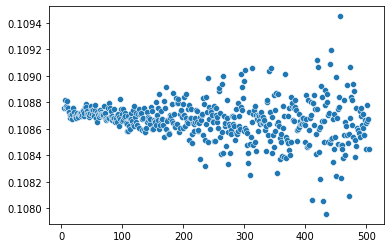

In [5]:
## View Distribution of RMSE
sns.scatterplot(x = list(range(5, 505)), y = lin_RMSE_ls[0:500])

In [53]:
## Export Fitting data

GI_Kd_distance_fit_DF = pd.DataFrame({'exponentialFit_RMSE': exp_RMSE_ls, 'linearFit_RMSE': lin_RMSE_ls, 'quantiles': list(range(5, 1001))})
#GI_Kd_distance_fit_DF.to_csv(directory + "R_GI_Network_Reconstruction/results/GI_Kd_distance_fit.csv")

## Retrieve Optimal Equation

In [6]:
## NOTE: Exponential Fit Seems to work well. A local minima is observed around q = 25. Use this value.


## Get equation relating distance to negative epistasis
# Sort by Distance
Kd_NegGI_DF['Association'] = 1/Kd_NegGI_DF['Distance']
Kd_NegGI_DF = Kd_NegGI_DF.sort_values(by = ['Association'], inplace = False)

# Assign Deciles
Kd_NegGI_DF['AssociationQuantile']= pd.qcut(Kd_NegGI_DF['Association'], q = 25, labels = False)
Kd_NegGI_DF['AssociationQuantile'] = Kd_NegGI_DF['AssociationQuantile'] + 1 # Deciles will now start at 1

# Get mean distance and mean scores per decile
Kd_NegGI_Quantile_DF = Kd_NegGI_DF.groupby(['AssociationQuantile']).agg({'Association': 'mean', 'scores': 'mean'})
Kd_NegGI_Quantile_DF

# Export Binned Table
#Kd_NegGI_Quantile_DF.to_csv(directory + "R_GI_Network_Reconstruction/results/Quantile_Dist_GI_Table.csv")

,Association,scores
AssociationQuantile,,
1,2.808888,-0.067101
2,3.588933,-0.071747
3,3.991925,-0.084146
4,4.284488,-0.078203
5,4.489458,-0.067554
6,4.672900,-0.068622
7,4.848606,-0.109910
8,4.977497,-0.129951
9,5.102080,-0.071580


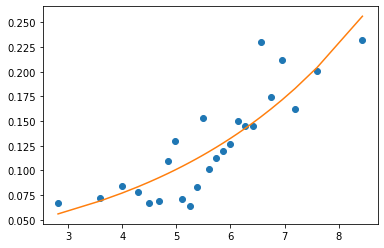

0.026271410579554545 0.26976154095524196
0.10837999833629754


In [7]:
popt, pcov = optimization.curve_fit(exp_func, Kd_NegGI_Quantile_DF['Association'], abs(Kd_NegGI_Quantile_DF['scores']), p0=[0.1, 0.1])
plt.plot(Kd_NegGI_Quantile_DF['Association'], abs(Kd_NegGI_Quantile_DF['scores']), 'o')
plt.plot(Kd_NegGI_Quantile_DF['Association'], exp_func(Kd_NegGI_Quantile_DF['Association'], *popt), '-')
plt.show()
print(popt[0], popt[1])

print(np.mean((abs(Kd_NegGI_Quantile_DF['scores']) - exp_func(Kd_NegGI_Quantile_DF['Association'], *popt)**2)))

In [ ]:
#def lin_func(dist, a): # Linear fit
#    lin = a*dist
#    return lin
#
#
#popt, pcov = optimization.curve_fit(lin_func, Kd_NegGI_Decile_DF['Association'], abs(Kd_NegGI_Decile_DF['scores']), p0=[0.1])
#plt.plot(Kd_NegGI_Decile_DF['Association'], abs(Kd_NegGI_Decile_DF['scores']), 'o')
#plt.plot(Kd_NegGI_Decile_DF['Association'], lin_func(Kd_NegGI_Decile_DF['Association'], *popt), '-')
#plt.show()
#print(popt[0])

#print(np.mean((abs(Kd_NegGI_Decile_DF['scores']) - lin_func(Kd_NegGI_Decile_DF['Association'], *popt)**2)))

## Construct Network and Extract Shortest Paths

In [57]:
## Construct Weighted PPI Network
Kd_GI_Network_G = nx.from_pandas_edgelist(Kd_GI_Network_DF, "source", "target", ["Distance"])

## Get all pair shortest paths lengths
Kd_GI_APSP_len_it = nx.shortest_path_length(Kd_GI_Network_G, source=None, target=None, weight="Distance", method='dijkstra')

# Extract adjacencies from adjacency list generator function
# Note: adjacency[0] will be a source node, adjacency[1] will be a dictionary with target nodes as keys and weight as entry
Kd_GI_APSP_len_dict = {adjacency[0]: adjacency[1] for adjacency in Kd_GI_APSP_len_it}

In [58]:
## Make 2D array representing all pairwise shortest path distances
node_list = np.array([key for key in Kd_GI_APSP_len_dict.keys()])

# Note: Data in the array will be ordered according to the node list
#           i.e., the ith element of node list will be the ith and jth in the array (where i==j)

## Initiate 2D array
Kd_GI_APSP_len_arr = np.empty(shape=(len(node_list), len(node_list)))
Kd_GI_APSP_len_arr.fill(np.nan) # Fill with distances of 1 (highest; weakest interaction)


## Fill Array with shortest path distances
for i, ORF in enumerate(node_list):
    adjacency_dict = Kd_GI_APSP_len_dict[ORF]
    
    for key in adjacency_dict.keys():
        j = np.where(node_list == key)[0][0]
        Kd_GI_APSP_len_arr[i,j] = adjacency_dict[key]
        Kd_GI_APSP_len_arr[j,i] = adjacency_dict[key]

## Make Reconstructed GI Matrix Using Shortest Paths Distances

In [59]:
## Convert to similarity matrix (1/d; 'mod distance') and apply fitted equation
Kd_GI_Sim_arr = 1/Kd_GI_APSP_len_arr
Kd_GI_inferred_arr = popt[0]*np.exp(popt[1]*Kd_GI_Sim_arr)
Kd_GI_inferred_arr[Kd_GI_inferred_arr == np.inf] = np.nan
Kd_GI_inferred_arr

/tmp/ipykernel_541320/2541302074.py:2: RuntimeWarning: divide by zero encountered in divide
  Kd_GI_Sim_arr = 1/Kd_GI_APSP_len_arr


array([[       nan, 0.12922798,        nan, ...,        nan,        nan,
               nan],
       [0.12922798,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan, 0.03809338,
        0.03570234],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan, 0.03809338, ...,        nan,        nan,
        0.03237916],
       [       nan,        nan, 0.03570234, ...,        nan, 0.03237916,
               nan]])

In [60]:
## Conserve Reconstructed Matrix as Dataframe
Kd_GI_inferred_arr_DF = pd.DataFrame(Kd_GI_inferred_arr)
Kd_GI_inferred_arr_DF.columns = node_list
Kd_GI_inferred_arr_DF.index = node_list
Kd_GI_inferred_arr_DF.index.name = "Gene"
Kd_GI_inferred_arr_DF

,YAL001C,YPL007C,YAL007C,YKR067W,YML012W,YAL011W,YJL081C,YNL107W,YAL021C,YJR011C,...,YPR006C,YOR244W,YPR024W,YPR028W,YPR155C,YMR092C,YPR172W,YLR456W,YPR173C,YPR185W
Gene,,,,,,,,,,,,,,,,,,,,,
YAL001C,NaN,0.129228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YPL007C,0.129228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YAL007C,NaN,NaN,NaN,0.106568,0.120953,0.037820,0.035137,0.035548,NaN,NaN,...,0.033305,0.033376,0.036263,0.037376,NaN,NaN,NaN,NaN,0.038093,0.035702
YKR067W,NaN,NaN,0.106568,NaN,0.054539,0.035079,0.033423,0.033689,NaN,NaN,...,0.032382,0.033352,0.037723,0.041652,NaN,NaN,NaN,NaN,0.035238,0.038910
YML012W,NaN,NaN,0.120953,0.054539,NaN,0.035256,0.033540,0.033815,NaN,NaN,...,0.033237,0.033306,0.034282,0.034984,NaN,NaN,NaN,NaN,0.035422,0.033917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YMR092C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.151071,NaN,NaN,NaN,NaN,NaN
YPR172W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.168383,NaN,NaN
YLR456W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.168383,NaN,NaN,NaN


In [51]:
## Export
#Kd_GI_inferred_arr_DF.to_csv(directory + "R_GI_Network_Reconstruction/results/Kd_inferred_GI.tsv", sep = "\t")

## Execute Cluster3 on tsv
## Use Rscript to convert CDT file to csv